<a href="https://colab.research.google.com/github/marceloccs/deep_learning_pos_ai/blob/main/Trilha_8_Uso_de_PyThorch_como_hyper_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Nome:** Marcelo Custodio Cruz Silva

##**Matricula:** 92123341

---

##**Curso:** Inteligencia Artificial

##**Turma:** B

*Link do arquivo no google colabs: https://colab.research.google.com/drive/1g1mPmaSRKiOUNAisZncCHuGc9Qz4syqn?usp=sharing*

*Link do arquivo no github: https://github.com/marceloccs/deep_learning_pos_ai/blob/main/Trilha_8_Uso_de_PyThorch_como_hyper_parametros.ipynb* 

#Trilha 8: Tarefa

Nesta tarefa você fará o ajuste automático dos hiperparâmetros do modelo TensorFlow que você desenvolveu na atividade da Trilha 4. O resultado do seu modelo deve ser acima de 0.8 de acuracidade sobre o conjunto de teste (0.3 dos dados de treinamento). Mostre sua seleção de valores de hiperparâmetros e os resultados apresentados ao final indicando a diferença obtida com relação ao modelo original.   

 

Se preferir, você pode fazer o tunning dos hiperparâmetros em PyTorch empregando a atividade da Trilha 6 como modelo inicial. 

 

Ao final, apresente as suas conclusões. 



Enviar a atividade em .pdf juntamente com o endereço do Python notebook 100% executável. 

##Preparos iniciais do modelo

###Imports para dependencias necessarias ao decorrer do modelo.

In [1]:
#Manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
#Auxiliar para leitura e print de dados
from IPython.display import display

###Leitura do arquivo para predição de cogumelos.

*Modelo de classificação binária para identificação se o cogumelo, pelas suas características físicas, é comestível ou venenoso.*

**Link Kaggle:** https://archive.ics.uci.edu/ml/datasets/Mushroom

**Link Github:** https://raw.githubusercontent.com/marceloccs/pos-ai-files/main/Trilha%204%20Uso%20de%20tensores%20com%20TenserFlow/agaricus-lepiota.data

A seguir é utilizado um dataset contendo diversas especies de cogumelos, as características vão ser utilizadas para definir se o cogumelo é venenoso ou comestível. Para realizar esse predição é utilizado o modelo de classificação binária.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/marceloccs/pos-ai-files/main/Trilha%204%20Uso%20de%20tensores%20com%20TenserFlow/agaricus-lepiota.data')
df = df.dropna()
display(df.head())

,classe,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


###Informações de atributos: 



     1. classes: comestíveis = e, venenosos = p
     2. forma de capa: sino = b, cônico = c, convexo = x, plano = f,knobbed = k, sunken = s
     3. superfície da capa: fibrosa = f, ranhuras = g, escamosa = y, lisa = s
     4. cor da tampa: marrom = n, amarelo-claro = b, canela = c, cinza = g, verde = r, rosa = p, roxo = u, vermelho = e, branco = w, amarelo = y
     5. hematomas ?: hematomas = t, não = f
     6. odor: amêndoa = a, anis = l, creosoto = c, peixe = y, fétido = f, mofo = m, nenhum = n, picante = p, picante = s 
     7. anexo de brânquia: anexado = a, descendente = d, livre = f, entalhado = n
     8. espaçamento entre guelras: próximo = c, lotado = w, distante = d
     9. tamanho da guelra: largo = b, estreito = n
     10. cor das guelras: preto = k, marrom = n, amarelo-claro = b, chocolate = h, cinza = g, verde = r, laranja = o, rosa = p, roxo = u, vermelho = e, branco = w, amarelo = y
     11. formato de haste: ampliação = e, afilamento = t
     12. raiz do caule: bulboso = b, clube = c, xícara = u, igual = e, rizomorfos = z, enraizado = r, ausente =?
     13. superfície da haste acima do anel: fibroso = f, escamoso = y, sedoso = k, liso = s
     14. superfície do caule abaixo do anel: fibroso = f, escamoso = y, sedoso = k, liso = s
     15. haste-cor-acima do anel: marrom = n, amarelo-claro = b, canela = c, cinza = g, laranja = o, rosa = p, vermelho = e, branco = w, amarelo = y
     16. cor-do-caule abaixo do anel: marrom = n, amarelo-claro = b, canela = c, cinza = g, laranja = o, rosa = p, vermelho = e, branco = w, amarelo = y
     17. tipo de véu: parcial = p, universal = u 
     18. cor do véu: marrom = n, laranja = o, branco = w, amarelo = y
     19. número do anel: nenhum = n, um = o, dois = t 19. tipo de anel: teia de aranha = c, evanescente = e, alargamento = f, grande = l, nenhum = n, pendente = p, revestimento = s, zona = z
     20. spore-print-color: black = k, brown = n, buff = b, chocolate = h, green = r, laranja = o, roxo = u, branco = w, amarelo = y
     21. população: abundante = a, agrupado = c, numeroso = n, espalhado = s, vários = v, solitário = y
     22. habitat: gramíneas = g, folhas = l, prados = m, caminhos = p, urbano = u, desperdício = w, madeiras = d

###Contagem de cogumelos por classe:

In [3]:
dfCount = df['classe'].value_counts()
display(dfCount)

e    4208
p    3916
Name: classe, dtype: int64

####Função Auxiliar para leitura descretização

*Como o modelo é para classificação binária, é necessario valores numéricos no modelo*
 
A função abaixo faz um Labbel enconder por valores na coluna, realizando uma discretização de valores.

In [4]:
def dataframeEncoding(dataframe):
    le = LabelEncoder()
    for i in range(len(dataframe.columns)):
        le.fit(dataframe.iloc[:,i])
        dataframe.iloc[:,i]  = le.transform(dataframe.iloc[:,i])
    return dataframe

In [5]:
df = dataframeEncoding(df)
display(df.head())

,classe,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,0,2,1,0,3,0,1


##Inicio do modelo, treinamento e resultado  

###Separação de modelos de teste e de treinamento

*Separando os grupos de teste e treino, com o tamanho de teste de 30% (ou 0.3) do modelo todo*

In [6]:
dfClassificacao = df.copy()
X = dfClassificacao.drop('classe', axis=1)
y = dfClassificacao[['classe']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
display(X_train.head())
display(y_train.head())

,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
716,0,2,8,1,3,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,3,3
36,4,0,3,0,5,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,4,5
336,5,3,4,1,0,1,0,0,10,0,4,2,3,7,7,0,2,1,4,2,5,1
8084,0,0,3,0,5,1,1,0,7,0,0,1,1,7,7,0,2,2,4,7,3,1
960,5,0,4,0,5,1,1,0,5,1,3,0,0,7,7,0,2,1,0,2,0,1


,classe
716,0
36,0
336,0
8084,0
960,0


###Modelo de aprendizado binario

**Abaixo o modelo criado possui 4 camadas**
1.   Camada linear, com o input com o valor de entrada e a saida dom o dobro do que o valor de entrada.
2.   Camada de regressão linear.
3.   Camada para Dropout, para evitar o overfitting do modelo.
4.   Camada de saída com sigmoid para manter os valores para classificação binaria. *Com o valor de saida de 1 neurônio e para entrada o valor da camada anterior a camada de dropout.*

In [18]:
class Encoder(nn.Module):
  def __init__(self,input_dim, p):
    super(Encoder,self).__init__()
    self.layer1 = nn.Linear(input_dim, input_dim*2)
    self.layer2 = nn.Linear(input_dim*2, input_dim*4)
    self.dropout = nn.Dropout()
    self.p = p

  def forward(self, x):
    x = torch.relu(self.layer1(x))
    x = torch.dropout(self.dropout(x),self.p,train=True)
    x = torch.relu(self.layer2(x))
    return x

class Decoder(nn.Module):
  def __init__(self,input_dim, p):
    super(Decoder,self).__init__()
    self.layer1 = nn.Linear(input_dim*4, input_dim*2)
    self.layer2 = nn.Linear(input_dim*2, 1)
    self.dropout = nn.Dropout()
    self.p = p

  def forward(self, z):
    z = torch.relu(self.layer1(z))
    z = torch.dropout(self.dropout(z),self.p,train=True)
    out = torch.sigmoid(self.layer2(z))
    return out
 
class Autoencoder(nn.Module):
  def __init__(self, input_dim, p):
    super(Autoencoder,self).__init__()
    self.Encoder = Encoder(input_dim,p)
    self.Decoder = Decoder(input_dim,p)

  def forward(self, x):
    z = self.Encoder(x)
    out =  self.Decoder(z)
    return out

In [19]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = len(self.x)
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X_train.to_numpy(),y_train.to_numpy())
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

**Função de perda é utilizado o "*binary_crossentropy*", como otimizado do modelo o "*adam*". Alem de declarar o modelo passando como parametro o tamanho da massa de treinamento e o parametro do dropout de probabilidade de elementos que serão zerados.**

In [20]:
model     = Autoencoder(X_train.shape[1],p=0.5)
optimizer = torch.optim.Adam(model.parameters())
loss_fn   = nn.BCELoss()
model

Autoencoder(
  (Encoder): Encoder(
    (layer1): Linear(in_features=22, out_features=44, bias=True)
    (layer2): Linear(in_features=44, out_features=88, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Decoder): Decoder(
    (layer1): Linear(in_features=88, out_features=44, bias=True)
    (layer2): Linear(in_features=44, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Criação do loop de aprendizado de 50 interações. Além da interação para aprendizado, algumas métricas são retiradas para visualização de gráfico do resultado do aprendizado.

In [21]:
import tqdm # somente para display da evolução do loop

EPOCHS = 50
loss_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    loss_batch = 0

    for x_batch, y_batch in trainloader:
        # compute the model output
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss_batch + loss.item()
    
    loss_list[epoch] = loss_batch / len(x_batch)
    

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


###Funções de auxilio para visualização do resultado do modelo.

In [22]:
def plot_history(loss_list):
  plt.plot(loss_list)
  plt.ylabel("Train Loss")
  plt.xlabel("Epoch")
  plt.show()

###Resultado do aprendizado:

Criação de DataSet para os conjuntos de teste.

In [23]:
testset = dataset(X_test.to_numpy(),y_test.to_numpy())
xx_test, yy_test = next(iter(testset))
yy_pred = model(xx_test).round()

Retirada de valor de acurancia do modelo, baseado no teste realizado

In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(yy_test.detach().numpy(), yy_pred.detach().numpy()))

1.0


Plot do grafico da função de perda.

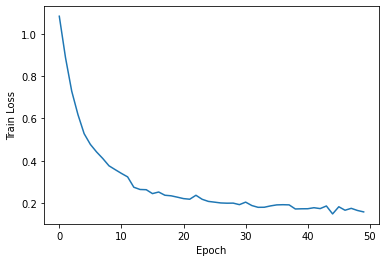

In [25]:
plot_history(loss_list)

##Conclusão

O modelo apresentado é um modelo simples para verificar se uma espécie de cogumelo é venenosa ou não baseado em suas características, o mesmo modelo foi feito no TensorFlow anteriormente, também foi feita uma implementação em PyTorch. Agora podemos voltar a avaliação das diferenças notadas entre as implementações em PyTorch simples para com o pytorch com Auto Encoder.

Ambas implementações do PyTorch para o modelo apresentaram resultados de acurácia e de Train Loss muito boas, porém ao focar na implementação de autoencoder podemos ver que com as redes neurais separadas em 2 classes aumenta bastante as possibilidades de criação de classes reutilizáveis. Aumentando o dinamismo de reutilização de componentes de inteligências artificiais.

Claramente esse não necessaria mente é o único insight que podemos tirar, a possibilidade de decode um valor para dados de interpretação do modelo, depois o encode nos valores em que precisamos torna a ferramenta muito versátil a mais situações complexas, por exemplo: encode e decode de imagens de cogumelos para a informação se o cogumelo é  venenoso ou não, ou captura de imagens sem cor para colori las durante o processamento e inúmeros outras opções.
